In [2033]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
from numpy import nan as NA
import os
import matplotlib.pyplot as plt
import re

In [2034]:
plt.rc('figure', figsize=(20,10))

In [2035]:
xls_file = pd.ExcelFile("Data/LeioX.xls")
book = xls_file.parse("Book")
rs = xls_file.parse("ReadingSession")

In [2036]:
# Fill out the Session Table
rs['BookID'] = rs['book'].map(lambda x: re.findall('\d+', x )[0])
rs['BookID'] = pd.to_numeric(rs['BookID'])
rs['Pages'] = rs['lastPage'] - rs['firstPage'] + 1

rs['SessionDuration'] = rs['duration'].map(lambda x: pd.Timedelta(seconds=x))
rs['PerPageDuration'] = rs.apply(lambda r: r['SessionDuration'] / r['Pages'], axis=1)

rs['SessionDuration_Minutes'] = rs.SessionDuration.map(lambda d: d.total_seconds() / 60)
rs['PerPageDuration_Seconds'] = rs.PerPageDuration.map(lambda d: d.total_seconds())

rs['SessionStart'] = pd.to_datetime(rs['start'], errors="coerce")
rs['SessionEnd'] = pd.to_datetime(rs['date'], errors="coerce")
rs['SessionDate'] = rs.SessionEnd

rs['SessionElapsed'] = rs.SessionEnd - rs.SessionStart
rs['SessionInterupt'] = rs.SessionElapsed - rs.SessionDuration

rs['Weekday'] = rs.SessionEnd.apply(lambda d: d.weekday())
rs['Month'] = rs.SessionEnd.apply(lambda d: d.month)

# This is used for tics in grpahs, keeping the numberic sort order but displaying names.
dayNames = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
monthNames=('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')

In [2037]:
# Fill out book table.
book = book.rename(columns={'Book#': 'BookID'})
book.fillna(value={'bookType': 'paper'}, inplace=True)
book['ArchiveDate'] = pd.to_datetime(book['date'], errors="coerce")
book['Pages'] = book['lastPage'] - book['firstPage'] + 1

book['SessionCount'] = book['BookID'].map(lambda x: rs[rs['BookID'] == x].BookID.count())

book['SessionDuration'] = book['BookID'].map(lambda x: rs[rs['BookID'] == x]['SessionDuration'].sum())
book['SessionDuration_Minutes'] = book.SessionDuration.map(lambda d: d.total_seconds() * 60)

book['PerPageDuration'] = book['BookID'].map(lambda x: rs[rs['BookID'] == x]['PerPageDuration'].mean())
book['PerPageDuration_Seconds'] = book.PerPageDuration.map(lambda d: d.total_seconds())

In [2038]:
book['FirstSession'] = book.BookID.map(lambda id: rs[rs.BookID == id].SessionEnd.min(), na_action="ignore")
book['LastSession'] = book.BookID.map(lambda id: rs[rs.BookID == id].SessionEnd.max(), na_action="ignore")
book['ElapsedSession'] = book['LastSession'] - book['FirstSession']
book['SessionEfficiency'] = book.SessionDuration.map(lambda x: x.total_seconds()) / book.ElapsedSession.map(lambda x: x.total_seconds())

In [2039]:
pageList = []
pageVars = []
for id in book.BookID:
    pages = book[book['BookID'] == id].Pages.max()
    new_pages = rs[rs['BookID'] == id].lastPage.max()
    pageVars.append({"bookdID": id, "pages": pages, "new_pages": new_pages})
    pageList.append(pages) if pages != 1 else pageList.append(new_pages)
book['Pages'] = pageList
pageList = []
for id in rs.BookID:
    pageList.append(book[book.BookID == id].Pages.max())
rs['BookPages'] = pageList

In [2040]:
rs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 21 columns):
BookID                     523 non-null int64
book                       523 non-null object
firstPage                  523 non-null int64
lastPage                   523 non-null int64
duration                   523 non-null float64
date                       523 non-null object
key                        523 non-null object
start                      523 non-null object
Pages                      523 non-null int64
SessionDuration            523 non-null timedelta64[ns]
PerPageDuration            523 non-null timedelta64[ns]
SessionDuration_Minutes    523 non-null float64
PerPageDuration_Seconds    523 non-null float64
SessionStart               63 non-null datetime64[ns]
SessionEnd                 515 non-null datetime64[ns]
SessionDate                515 non-null datetime64[ns]
SessionElapsed             63 non-null timedelta64[ns]
SessionInterupt            63 non-null timedelta

In [2041]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 32 columns):
BookID                     51 non-null int64
title                      51 non-null object
author                     51 non-null object
firstPage                  51 non-null int64
lastPage                   51 non-null int64
key                        51 non-null object
readingUnit                51 non-null object
outOfOrder                 51 non-null bool
archived                   51 non-null bool
date                       51 non-null object
scheduledDate              51 non-null object
schedulingDate             51 non-null object
scheduledTime              51 non-null int64
scheduledPages             51 non-null int64
scheduledDays              51 non-null int64
order                      51 non-null int64
scheduledWeekdays          51 non-null object
bookType                   51 non-null object
rating                     51 non-null int64
comment                    0 non-nu

In [2042]:
res = pd.merge(rs,book,left_on='BookID', right_on='BookID', suffixes=('_sess', '_book'))

In [2043]:
res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 0 to 522
Data columns (total 52 columns):
BookID                          523 non-null int64
book                            523 non-null object
firstPage_sess                  523 non-null int64
lastPage_sess                   523 non-null int64
duration                        523 non-null float64
date_sess                       523 non-null object
key_sess                        523 non-null object
start                           523 non-null object
Pages_sess                      523 non-null int64
SessionDuration_sess            523 non-null timedelta64[ns]
PerPageDuration_sess            523 non-null timedelta64[ns]
SessionDuration_Minutes_sess    523 non-null float64
PerPageDuration_Seconds_sess    523 non-null float64
SessionStart                    63 non-null datetime64[ns]
SessionEnd                      515 non-null datetime64[ns]
SessionDate                     515 non-null datetime64[ns]
SessionElapsed         

In [2044]:
# Create the final Session table and index on Session Date.
sess_table = res.set_index('SessionDate')
sess_table = sess_table.rename(columns={
                            'archived': 'Archived',
                            'author': 'Author',
                            'DurationPerPage_sess': 'DurationPerPage',
                            'firstPage_sess':'FirstSessionPage',
                            'key_sess': 'Key',
                            'lastPage_sess': 'LastSessionPage',
                            'readingUnit': 'ReadingUnit',
                            'start': 'Start',
                            'title': 'Title', 
                            'Pages_sess': 'PagesRead',
                            'Pages_book': 'BookPages',
                            'PerPageDuration_sess': 'PerPageDuration',
                            'SessionDuration_sess': 'Duration',
                            'SessionDuration_Minutes_sess': "SessionDuration_Minutes",
                            'PerPageDuration_Seconds_sess': "PerPageDuration_Seconds"
                           })
sess_table = sess_table.drop(['book', 'bookType', 'comment', 'date_book', 'date_sess', 'duration', 'firstPage_book', 'firstPage_sess', 
                  'key_book', 'key_sess', 'lastPage_book', 'lastPage_sess', 'order','outOfOrder','rating',
                  'scheduledDate', 'scheduledDays', 'scheduledTime', 'scheduledPage', 'scheduledPages', 'scheduledWeekdays',
                  'schedulingDate',
                  'start', 'startDate', 'title',
                  'DurationPerPage_sess', 'Pages_book', 'Pages_sess', 'SessionDuration_book'], axis=1)


In [2045]:
sess_table.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2017-03-07 05:00:00 to 2018-01-10 07:34:46
Data columns (total 31 columns):
BookID                          523 non-null int64
FirstSessionPage                523 non-null int64
LastSessionPage                 523 non-null int64
Key                             523 non-null object
Start                           523 non-null object
PagesRead                       523 non-null int64
Duration                        523 non-null timedelta64[ns]
PerPageDuration                 523 non-null timedelta64[ns]
SessionDuration_Minutes         523 non-null float64
PerPageDuration_Seconds         523 non-null float64
SessionStart                    63 non-null datetime64[ns]
SessionEnd                      515 non-null datetime64[ns]
SessionElapsed                  63 non-null timedelta64[ns]
SessionInterupt                 63 non-null timedelta64[ns]
Weekday                         515 non-null float64
Month                         

In [2046]:
year_to_date = ["3/1/2017", "1/11/2018"]

In [2047]:
# Create the final book table.
book_table = book.rename(columns={
                        'archived': 'Archived', 
                        'author': 'Author',
                        'bookType': 'BookType',
                        'date': 'Date',
                        'key': 'Key', 
                        'order': 'Order',
                        'title': 'Title',
                        'firstPage': 'FirstPage', 
                        'lastPage':'LastPage',
                        'outOfOrder': 'OutOfOrder',
                        'PerPageDuration_book': 'PerPageDuration',
                        'rating': 'Rating',
                        'readingUnit': 'ReadingUnit',
                        'startDate': 'StartDate'
                       })
book_table = book_table.drop([
   'scheduledDate', 'scheduledDays','scheduledPages', 'scheduledTime', 'scheduledWeekdays',
   'schedulingDate'
], axis=1)

In [2048]:
book_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 26 columns):
BookID                     51 non-null int64
Title                      51 non-null object
Author                     51 non-null object
FirstPage                  51 non-null int64
LastPage                   51 non-null int64
Key                        51 non-null object
ReadingUnit                51 non-null object
OutOfOrder                 51 non-null bool
Archived                   51 non-null bool
Date                       51 non-null object
Order                      51 non-null int64
BookType                   51 non-null object
Rating                     51 non-null int64
comment                    0 non-null float64
StartDate                  51 non-null object
ArchiveDate                30 non-null datetime64[ns]
Pages                      50 non-null float64
SessionCount               51 non-null int64
SessionDuration            51 non-null timedelta64[ns]
SessionDuration

In [2049]:
book_table.describe()

,BookID,FirstPage,LastPage,Order,Rating,comment,Pages,SessionCount,SessionDuration,SessionDuration_Minutes,PerPageDuration,PerPageDuration_Seconds,ElapsedSession,SessionEfficiency
count,51.000000,51.000000,51.000000,51.000000,51.0,0.0,50.000000,51.000000,51,5.100000e+01,49,49.000000,48,45.000000
mean,25.000000,1.509804,391.803922,8.627451,0.0,NaN,430.920000,10.254902,0 days 05:38:47.442308,1.219647e+06,0 days 00:01:14.572009,74.572010,32 days 07:23:06.708333,inf
std,14.866069,4.365192,232.421601,6.734867,0.0,NaN,199.711612,11.753881,0 days 08:04:46.643293,1.745199e+06,0 days 00:01:08.295598,68.295599,54 days 20:42:16.101404,NaN
min,0.000000,0.000000,0.000000,0.000000,0.0,NaN,105.000000,0.000000,0 days 00:00:00,0.000000e+00,0 days 00:00:00,0.000000,0 days 00:00:00,0.000000
25%,12.500000,1.000000,227.500000,2.000000,0.0,NaN,265.000000,2.000000,0 days 00:12:45.332198,4.591993e+04,0 days 00:00:28.271958,28.271959,0 days 20:21:40.500000,0.004327
50%,25.000000,1.000000,386.000000,7.000000,0.0,NaN,410.500000,5.000000,0 days 01:27:57.036187,3.166222e+05,0 days 00:01:16.617396,76.617396,11 days 00:52:28,0.021442
75%,37.500000,1.000000,538.500000,15.000000,0.0,NaN,561.000000,13.500000,0 days 07:25:06.260900,1.602376e+06,0 days 00:01:43.736542,103.736543,32 days 17:18:42.500000,0.041070
max,50.000000,32.000000,853.000000,24.000000,0.0,NaN,853.000000,44.000000,1 days 08:14:55.813031,6.965749e+06,0 days 00:06:37.133631,397.133631,250 days 12:25:16,inf


In [2050]:
sess_table.describe()

,BookID,FirstSessionPage,LastSessionPage,PagesRead,Duration,PerPageDuration,SessionDuration_Minutes,PerPageDuration_Seconds,SessionElapsed,SessionInterupt,Weekday,Month,BookPages,BookPages,SessionCount,SessionDuration_Minutes_book,PerPageDuration_book,PerPageDuration_Seconds_book,ElapsedSession,SessionEfficiency
count,523.00000,523.000000,523.000000,523.000000,523,523,523.000000,523.000000,63,63,515.000000,515.000000,523.000000,523.000000,523.000000,5.230000e+02,523,523.000000,522,519.000000
mean,15.50478,248.426386,272.068834,24.642447,0 days 00:33:02.217127,0 days 00:01:34.488860,33.036952,94.488860,0 days 01:24:28.587301,0 days 00:37:39.959637,3.234951,7.106796,544.596558,544.596558,23.462715,3.050557e+06,0 days 00:01:34.488860,94.488860,44 days 02:10:01.327586,inf
std,13.14965,204.426372,203.712439,28.042870,0 days 00:26:41.900130,0 days 00:00:54.504116,26.698336,54.504117,0 days 02:25:08.414643,0 days 02:22:43.376901,2.149369,2.953968,195.459043,195.459043,13.423262,2.173712e+06,0 days 00:00:43.187927,43.187927,51 days 00:20:59.364927,NaN
min,0.00000,1.000000,1.000000,1.000000,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,0 days 00:00:13,-1 days +23:59:13,0.000000,1.000000,105.000000,105.000000,1.000000,0.000000e+00,0 days 00:00:00,0.000000,0 days 00:00:00,0.000000
25%,6.00000,80.500000,106.000000,13.000000,0 days 00:14:03.542940,0 days 00:01:07.112008,14.059049,67.112008,0 days 00:34:07,0 days 00:00:00.229874,1.000000,5.000000,386.000000,386.000000,12.000000,9.489265e+05,0 days 00:01:00.887247,60.887247,17 days 00:58:34,0.009413
50%,11.00000,202.000000,225.000000,19.000000,0 days 00:30:00,0 days 00:01:40.289036,30.000000,100.289036,0 days 00:52:29,0 days 00:00:53.038188,3.000000,7.000000,552.000000,552.000000,25.000000,2.922282e+06,0 days 00:01:43.736542,103.736543,31 days 10:36:58,0.022870
75%,24.50000,388.000000,410.500000,29.000000,0 days 00:46:17.622147,0 days 00:02:07.381488,46.293702,127.381489,0 days 01:24:05.500000,0 days 00:24:02.878657,5.000000,10.000000,731.000000,731.000000,32.000000,4.457733e+06,0 days 00:02:10.120944,130.120945,63 days 17:56:13,0.033644
max,50.00000,772.000000,817.000000,484.000000,0 days 04:09:40.099467,0 days 00:06:37.133631,249.668324,397.133631,0 days 19:10:59,0 days 18:30:03.480755,6.000000,12.000000,853.000000,853.000000,44.000000,6.965749e+06,0 days 00:06:37.133631,397.133631,250 days 12:25:16,inf


# Books

In [2122]:
book_stats = book_table[['Title', 'Pages', 'PerPageDuration', 'ArchiveDate', 'SessionCount', 'FirstSession', 'LastSession',  'SessionDuration', ]]

### List of Books Read

In [2123]:
book_stats.sort_values('LastSession')

,Title,Pages,PerPageDuration,ArchiveDate,SessionCount,FirstSession,LastSession,SessionDuration
42,The Framers Coup,631.0,00:00:00,2017-02-13 02:14:25,2,2016-12-23 20:00:00,2017-02-12 20:00:00,0 days 00:00:00
43,Explaining America: The Federalist,270.0,00:00:00,2017-02-17 02:17:14,2,2016-11-08 20:00:00,2017-02-17 02:00:00,0 days 00:00:00
44,Anti-Intellectualism in American Life,432.0,00:00:00,2017-02-25 02:22:12,2,2016-11-18 20:00:00,2017-02-24 20:00:00,0 days 00:00:00
45,Madison's Hand,262.0,00:00:00,2017-03-07 02:25:22,2,2017-01-03 20:00:00,2017-03-06 20:00:00,0 days 00:00:00
0,Washington: A Life,817.0,00:02:13.474947,2017-03-30 06:44:35,22,2017-03-07 05:00:00,2017-03-30 06:36:21,0 days 13:31:44.692626
4,The Goal A Process of Ongoing Improvement,359.0,00:00:37.580579,2017-05-04 14:55:25,5,2017-04-14 08:06:02,2017-04-16 06:59:00,0 days 03:51:00.601992
2,"Plain, Honest Men: The Making of the American ...",423.0,00:01:39.746303,2017-04-27 21:00:11,21,2017-03-29 21:08:00,2017-04-27 20:55:50,0 days 09:38:54.723784
1,Alexander Hamilton,731.0,00:02:10.120944,2017-05-03 22:55:11,44,2017-04-01 05:17:43,2017-05-03 22:54:12,1 days 04:00:14.400966
12,A Gambler's Anatomy,289.0,00:01:23.213627,2017-05-21 03:21:51,14,2017-05-07 23:57:26,2017-05-21 03:20:32,0 days 06:45:44.861559
16,Hands-On Machine Learning with Scikit-Learn an...,525.0,00:01:15.633454,NaT,3,2017-05-23 04:53:42,2017-05-23 18:30:57,0 days 00:57:33.232306


In [2129]:
book_stats[(book_stats.SessionCount > 3)].describe()

,Pages,PerPageDuration,SessionCount,SessionDuration
count,28.000000,28,28.000000,28
mean,475.714286,0 days 00:01:21.786262,17.392857,0 days 09:48:55.606111
std,212.470104,0 days 00:00:39.847057,11.754713,0 days 08:56:00.503742
min,138.000000,0 days 00:00:00,4.000000,0 days 00:00:00
25%,287.750000,0 days 00:00:49.073012,9.000000,0 days 02:26:30.277406
50%,450.000000,0 days 00:01:22.261026,13.000000,0 days 06:30:58.166961
75%,643.750000,0 days 00:01:50.220886,25.750000,0 days 14:24:38.954679
max,853.000000,0 days 00:02:25.253628,44.000000,1 days 08:14:55.813031


In [2052]:
archived = DataFrame(book_table[book_table.Archived == True])

In [2053]:
di_archived = DataFrame(archived.sort_values('ArchiveDate').values, index=archived.sort_values('ArchiveDate').ArchiveDate.values, columns=archived.columns)

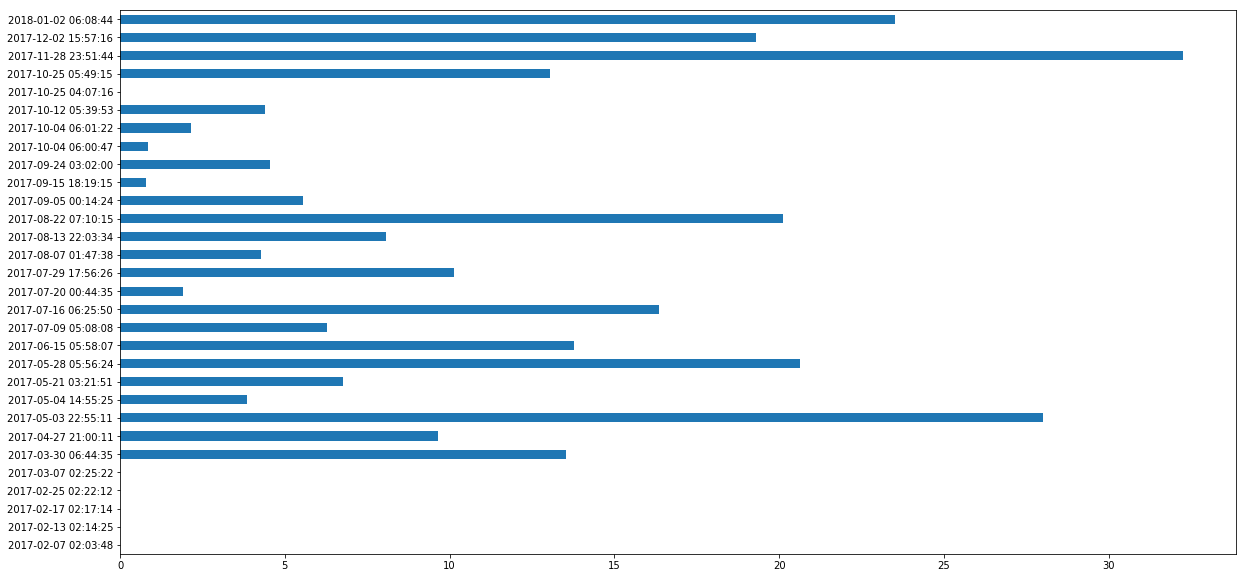

In [2054]:
di_archived.SessionDuration.map(lambda d: d.total_seconds() / 60 / 60).plot(kind="barh")

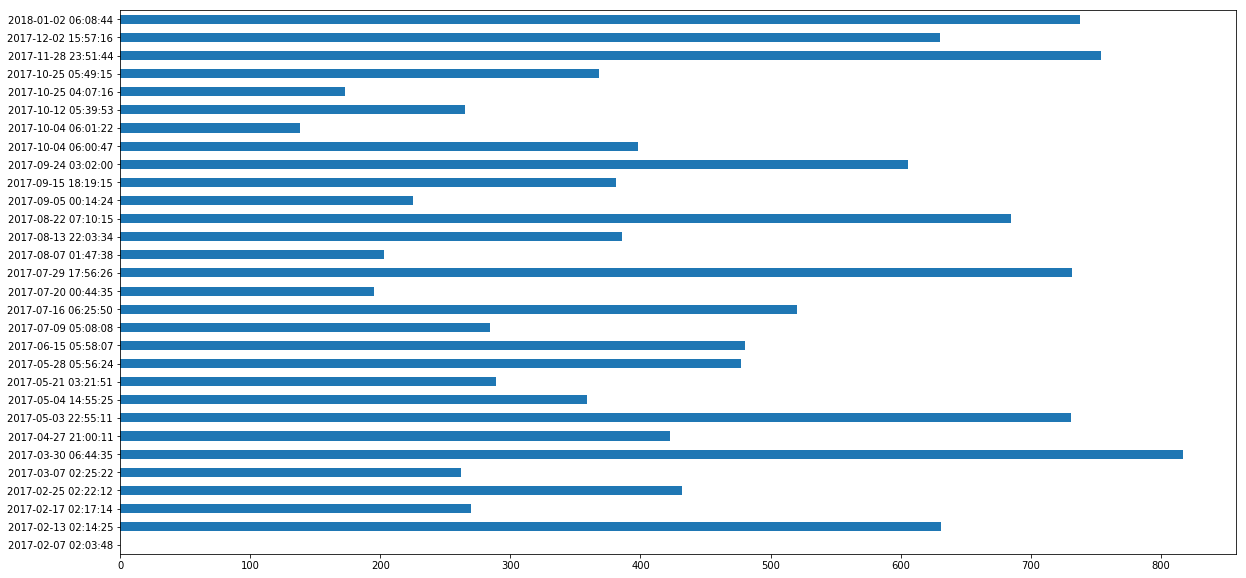

In [2055]:
di_archived.Pages.plot(kind="barh")

In [2056]:
di_archived.sort_values('ArchiveDate')[['Title','LastPage','SessionDuration', 'ElapsedSession']]

,Title,LastPage,SessionDuration,ElapsedSession
2017-02-07 02:03:48,Ratification: The People Debate the Constituti...,0,0 days 00:00:00,NaT
2017-02-13 02:14:25,The Framers Coup,0,0 days 00:00:00,51 days 00:00:00
2017-02-17 02:17:14,Explaining America: The Federalist,0,0 days 00:00:00,100 days 06:00:00
2017-02-25 02:22:12,Anti-Intellectualism in American Life,0,0 days 00:00:00,98 days 00:00:00
2017-03-07 02:25:22,Madison's Hand,0,0 days 00:00:00,62 days 00:00:00
2017-03-30 06:44:35,Washington: A Life,817,0 days 13:31:44.692626,23 days 01:36:21
2017-04-27 21:00:11,"Plain, Honest Men: The Making of the American ...",423,0 days 09:38:54.723784,28 days 23:47:50
2017-05-03 22:55:11,Alexander Hamilton,731,1 days 04:00:14.400966,32 days 17:36:29
2017-05-04 14:55:25,The Goal A Process of Ongoing Improvement,359,0 days 03:51:00.601992,1 days 22:52:58
2017-05-21 03:21:51,A Gambler's Anatomy,289,0 days 06:45:44.861559,13 days 03:23:06


In [2125]:
archived[['Pages','SessionCount', 'SessionDuration_Minutes', 'PerPageDuration_Seconds']].corr()

,LastPage,Pages,SessionCount,SessionDuration_Minutes,PerPageDuration_Seconds
LastPage,1.000000,0.797287,0.850852,0.807199,0.711416
Pages,0.797287,1.000000,0.719743,0.701435,0.459815
SessionCount,0.850852,0.719743,1.000000,0.918405,0.729647
SessionDuration_Minutes,0.807199,0.701435,0.918405,1.000000,0.858500
PerPageDuration_Seconds,0.711416,0.459815,0.729647,0.858500,1.000000


In [2126]:
book_table[['Pages','SessionCount', 'SessionDuration_Minutes', 'PerPageDuration_Seconds']].corr()

,Pages,SessionCount,SessionDuration_Minutes,PerPageDuration_Seconds
Pages,1.000000,0.515707,0.528316,0.357029
SessionCount,0.515707,1.000000,0.933625,0.269176
SessionDuration_Minutes,0.528316,0.933625,1.000000,0.370474
PerPageDuration_Seconds,0.357029,0.269176,0.370474,1.000000


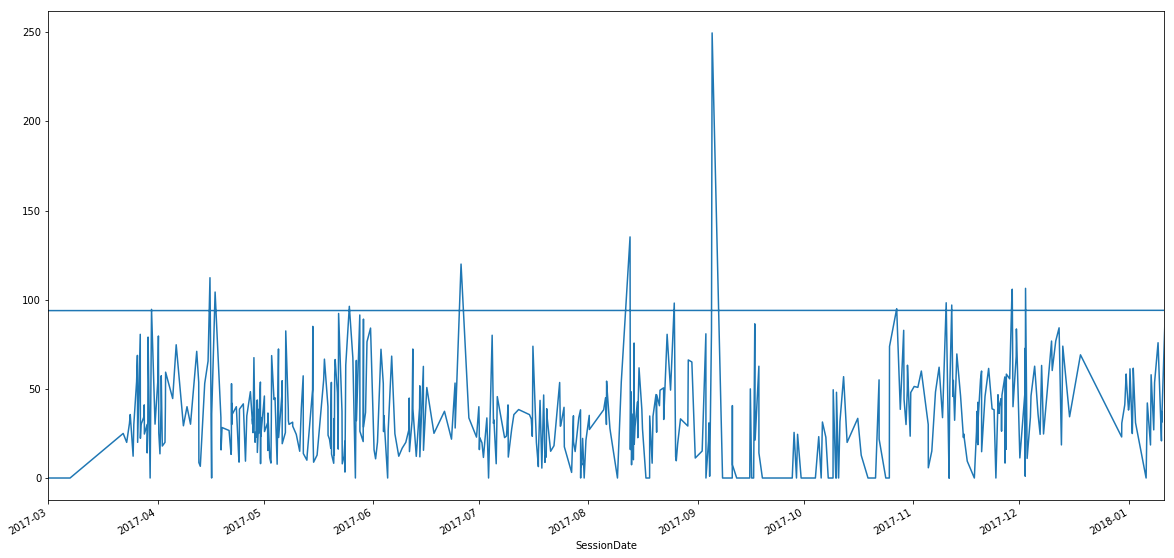

In [2059]:
sess_table['Duration'].map(lambda d: d.total_seconds() / 60 ).plot()
plt.xlim(year_to_date)
plt.show()

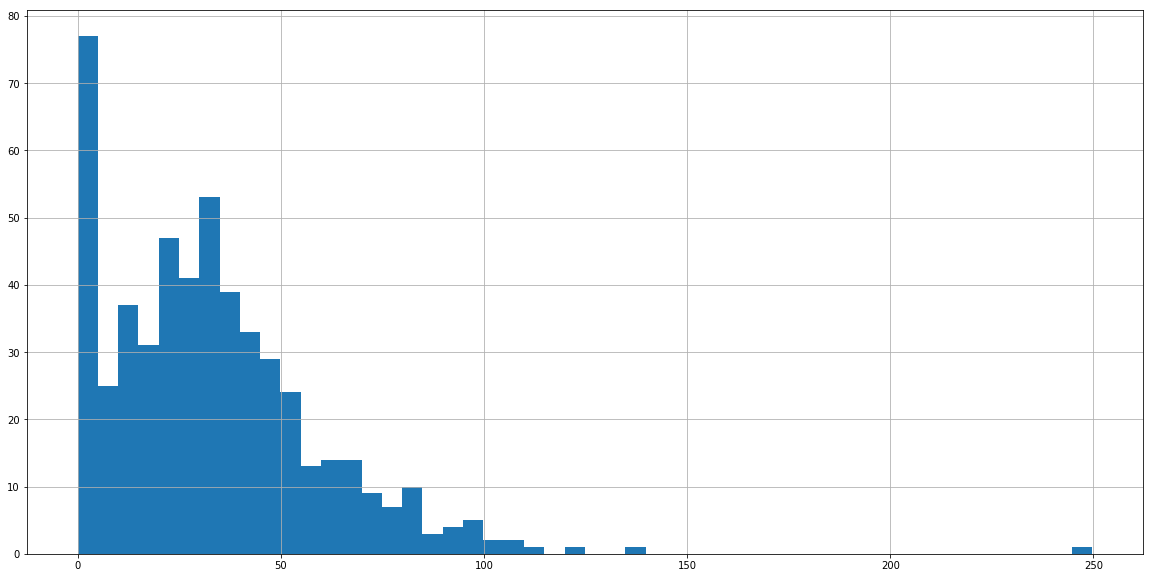

In [2060]:
sess_table['Duration'].map(lambda d: d.total_seconds() / 60 ).hist(bins=50)

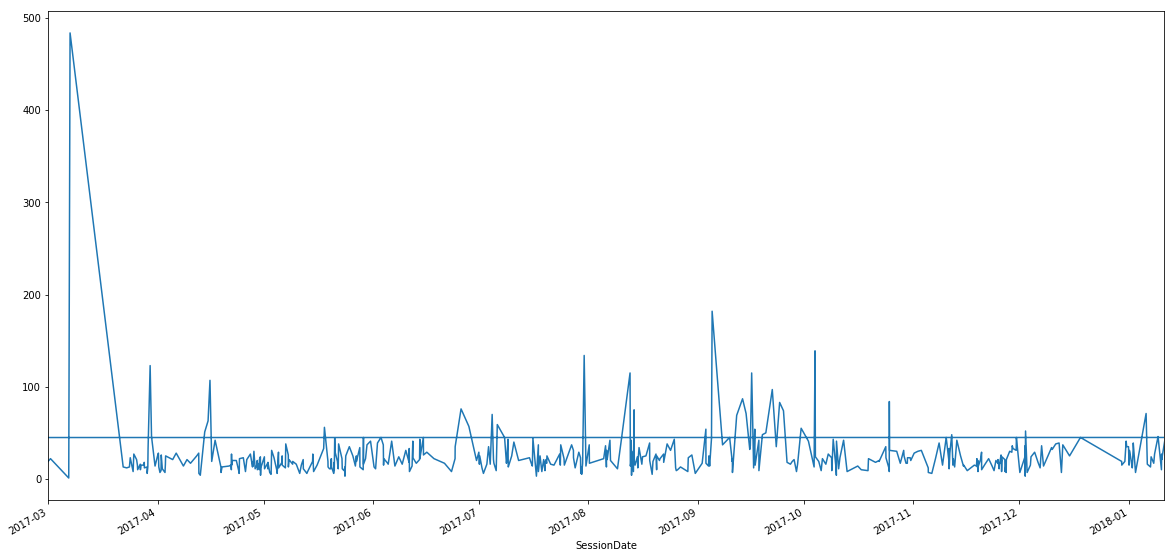

In [2061]:
sess_table['PagesRead'].plot()
plt.xlim(year_to_date)
plt.show()

In [2062]:
s = sess_table.PagesRead.cumsum()

(736389.0, 736705.0)

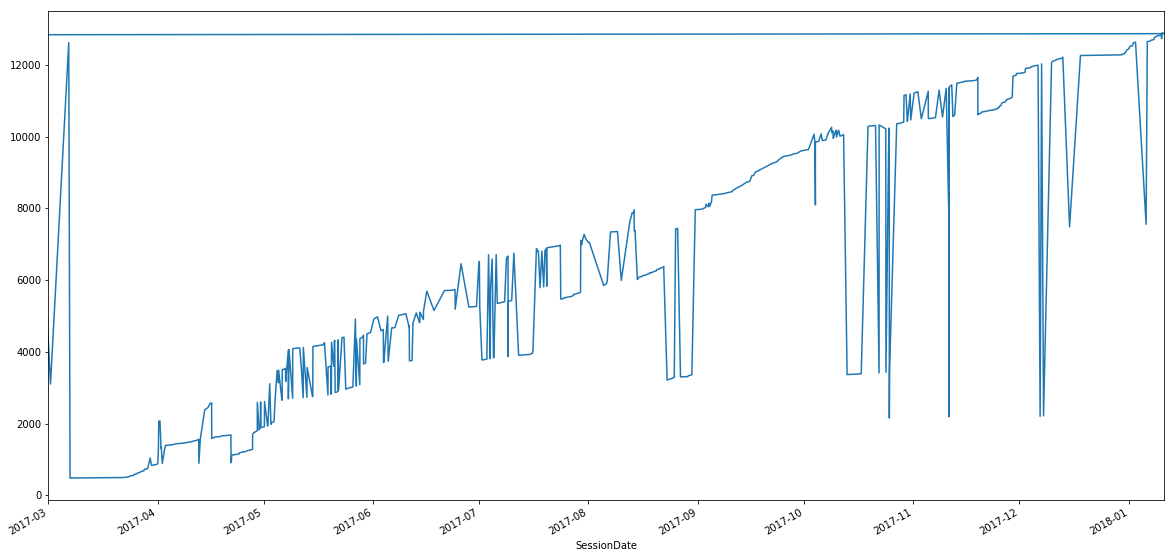

In [2063]:
sess_table['PagesRead'].cumsum().plot()
plt.xlim(year_to_date)

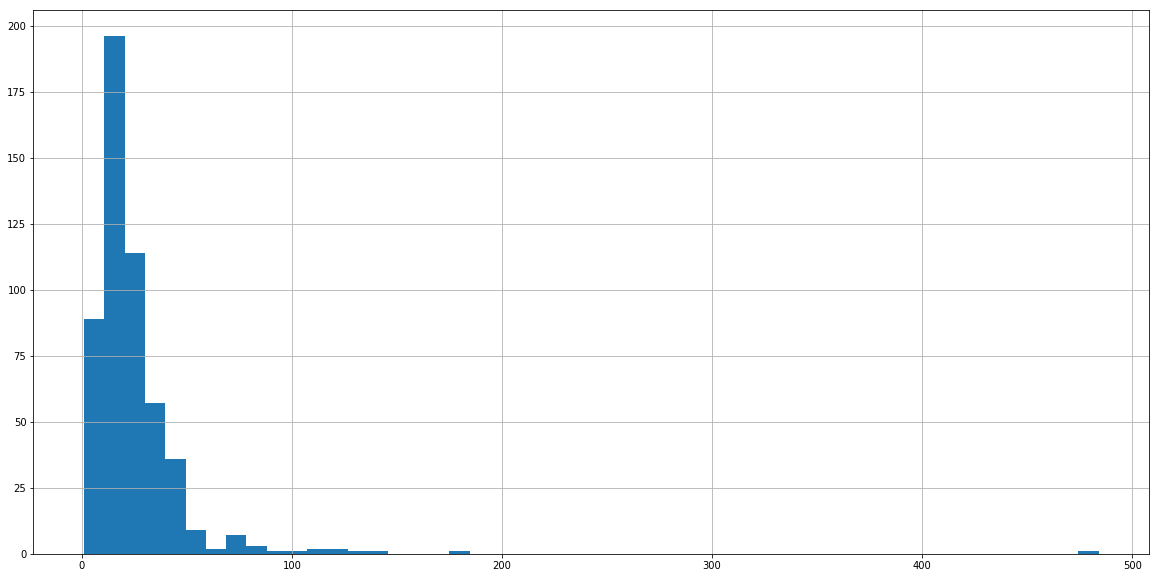

In [2064]:
sess_table['PagesRead'].hist(bins=50)
plt.show()

In [2065]:
sess_table.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2017-03-07 05:00:00 to 2018-01-10 07:34:46
Data columns (total 31 columns):
BookID                          523 non-null int64
FirstSessionPage                523 non-null int64
LastSessionPage                 523 non-null int64
Key                             523 non-null object
Start                           523 non-null object
PagesRead                       523 non-null int64
Duration                        523 non-null timedelta64[ns]
PerPageDuration                 523 non-null timedelta64[ns]
SessionDuration_Minutes         523 non-null float64
PerPageDuration_Seconds         523 non-null float64
SessionStart                    63 non-null datetime64[ns]
SessionEnd                      515 non-null datetime64[ns]
SessionElapsed                  63 non-null timedelta64[ns]
SessionInterupt                 63 non-null timedelta64[ns]
Weekday                         515 non-null float64
Month                         

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f044230fac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f04420e2400>]], dtype=object)

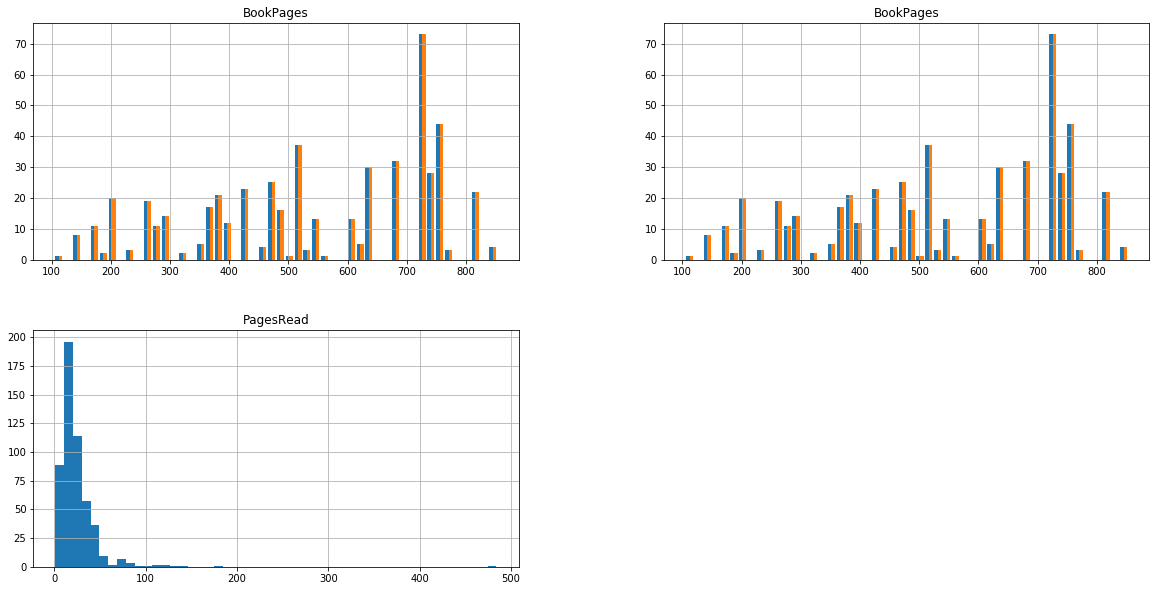

In [2066]:
sess_table[['Duration','BookPages','PerPageDuration','PagesRead']].hist(bins=50)

(0, 60)

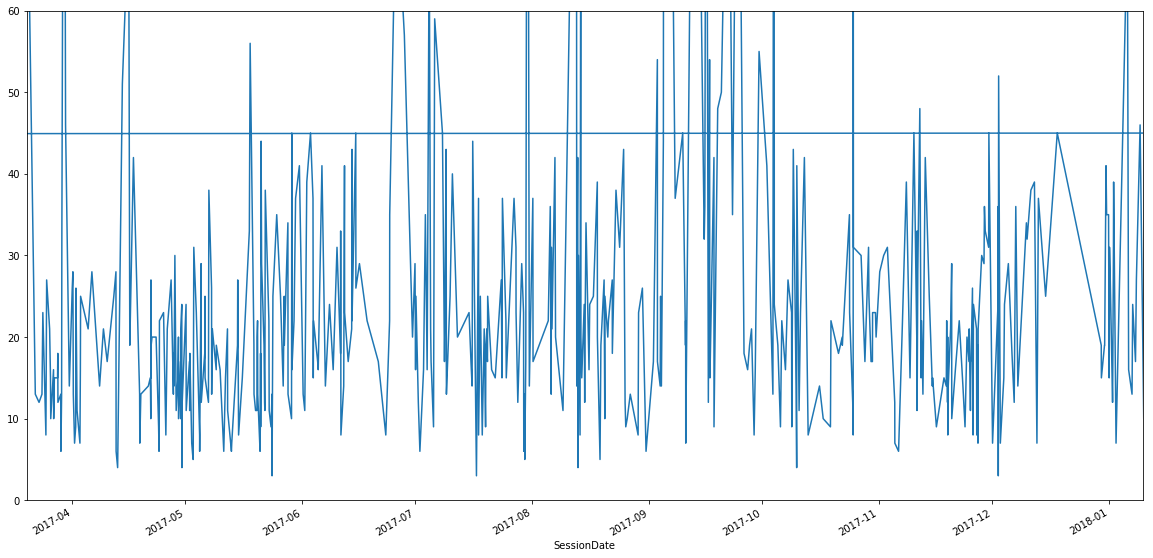

In [2067]:
sess_table.PagesRead.plot()
plt.xlim(['3/20/2017', '1/10/2018'])
plt.ylim([0,60])

(736408.0, 736704.0)

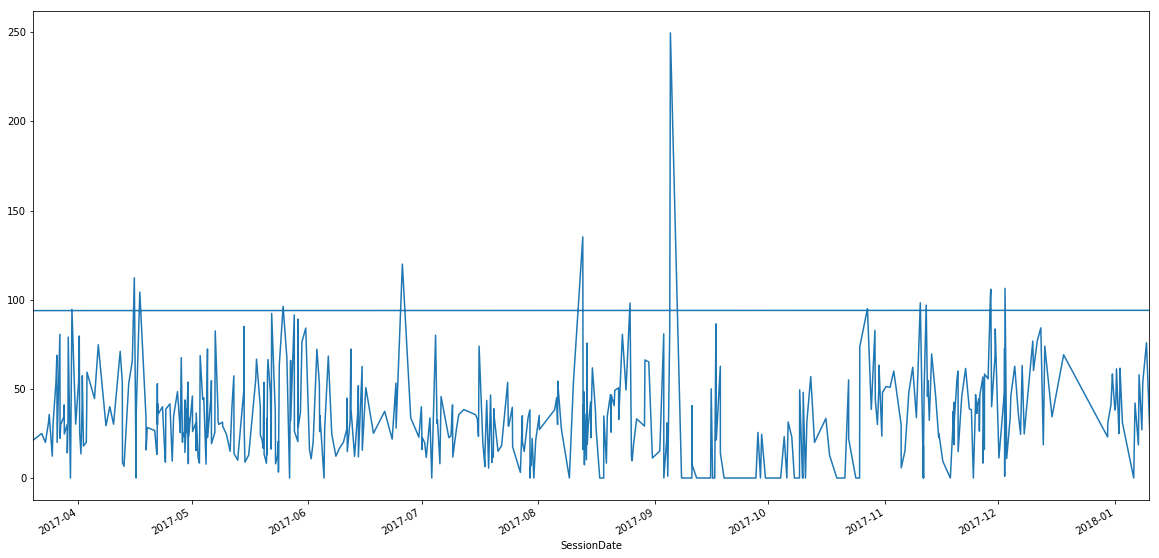

In [2068]:
sess_table.Duration.map(lambda d: d.total_seconds() / 60 ).plot()
plt.xlim(['3/20/2017', '1/10/2018'])

In [2069]:
byBook = sess_table.groupby(sess_table['Title'])

In [2070]:
byBook.mean().sort_values('Archived')

,BookID,FirstSessionPage,LastSessionPage,PagesRead,SessionDuration_Minutes,PerPageDuration_Seconds,Weekday,Month,BookPages,Archived,BookPages,SessionCount,SessionDuration_Minutes_book,PerPageDuration_Seconds_book,SessionEfficiency
Title,,,,,,,,,,,,,,,
Fates and Furies,23.0,9.000000,23.500000,15.500000,21.708913,84.637889,3.000000,7.000000,390.0,False,390.0,2.0,1.563042e+05,84.637889,0.032008
IOS 10 SDK Development: Creating iPhone and iPad Apps with Swift,21.0,1.000000,134.000000,134.000000,0.000000,0.000000,6.000000,7.000000,230.0,False,230.0,1.0,0.000000e+00,0.000000,NaN
"Hands-On Machine Learning with Scikit-Learn and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems",16.0,18.333333,31.333333,14.000000,19.184624,75.633454,1.000000,5.000000,525.0,False,525.0,3.0,2.071939e+05,75.633454,0.070424
Fundamentals of Deep Learning: Designing Next-Generation Artificial Intelligence Algorithms,27.0,1.000000,17.000000,17.000000,0.000000,0.000000,6.000000,9.000000,276.0,False,276.0,1.0,0.000000e+00,0.000000,NaN
Friends Divided: John Adams and Thomas Jefferson,39.0,1.000000,23.000000,23.000000,23.473264,61.234602,1.000000,10.000000,453.0,False,453.0,1.0,8.450375e+04,61.234602,inf
Learning React: Functional Web Development with React and Redux,37.0,9.500000,27.000000,18.500000,10.907743,34.445505,5.500000,10.000000,327.0,False,327.0,2.0,7.853575e+04,34.445505,0.014917
The Inheritance of Rome: Illuminating the Dark Ages 400-1000,50.0,1.000000,21.000000,21.000000,31.272439,89.349827,2.000000,1.000000,564.0,False,564.0,1.0,1.125808e+05,89.349827,inf
What Happened,35.0,1.000000,23.000000,23.000000,0.000000,0.000000,6.000000,10.000000,464.0,False,464.0,1.0,0.000000e+00,0.000000,NaN
Empires and Barbarians,49.0,43.600000,70.200000,27.600000,52.455003,115.215763,1.500000,1.000000,618.0,False,618.0,5.0,9.441901e+05,115.215763,0.060155


In [2071]:
byBook.sum()[['SessionDuration_Minutes', 'PagesRead']].sort_values('PagesRead')

,SessionDuration_Minutes,PagesRead
Title,,
Madison's Hand,0.000000,2
The Framers Coup,0.000000,2
Anti-Intellectualism in American Life,0.000000,2
Explaining America: The Federalist,0.000000,2
Thomas Jefferson: The Art of Power,19.856682,3
Capitalism and a New Social Order: The Repubkican Vision of the 1790s,0.000000,7
Fundamentals of Deep Learning: Designing Next-Generation Artificial Intelligence Algorithms,0.000000,17
On Human Nature,5.654392,19
The Inheritance of Rome: Illuminating the Dark Ages 400-1000,31.272439,21


In [2072]:
byWeekday = sess_table.groupby(sess_table['Weekday'])
byWeekday.sum()[['PerPageDuration_Seconds', 'SessionDuration_Minutes','PagesRead']]

,PerPageDuration_Seconds,SessionDuration_Minutes,PagesRead
Weekday,,,
0.0,8560.712197,2785.027190,1801
1.0,6219.491661,2412.619062,2012
2.0,5735.796436,1967.376586,1727
3.0,4350.699224,1688.243881,1265
4.0,5013.641956,1693.223003,1215
5.0,8838.660026,3008.925294,2220
6.0,10471.043400,3670.972790,2378


In [2073]:
byWeekday.mean()[['SessionDuration_Minutes', 'PerPageDuration_Seconds','PagesRead']]

,SessionDuration_Minutes,PerPageDuration_Seconds,PagesRead
Weekday,,,
0.0,35.253509,108.363446,22.797468
1.0,36.554834,94.234722,30.484848
2.0,30.267332,88.243022,26.569231
3.0,33.102821,85.307828,24.803922
4.0,30.236125,89.529321,21.696429
5.0,31.672898,93.038527,23.368421
6.0,35.640513,101.660616,23.087379


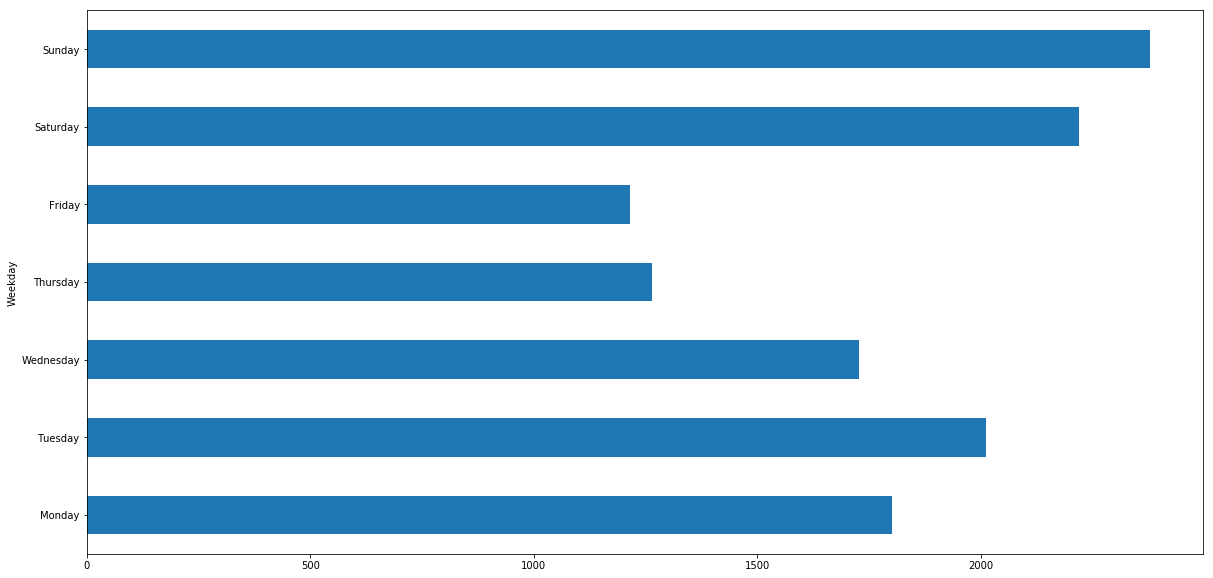

In [2074]:
byWeekday.sum().PagesRead.plot.barh()
plt.yticks(np.arange(7),dayNames)
plt.show()

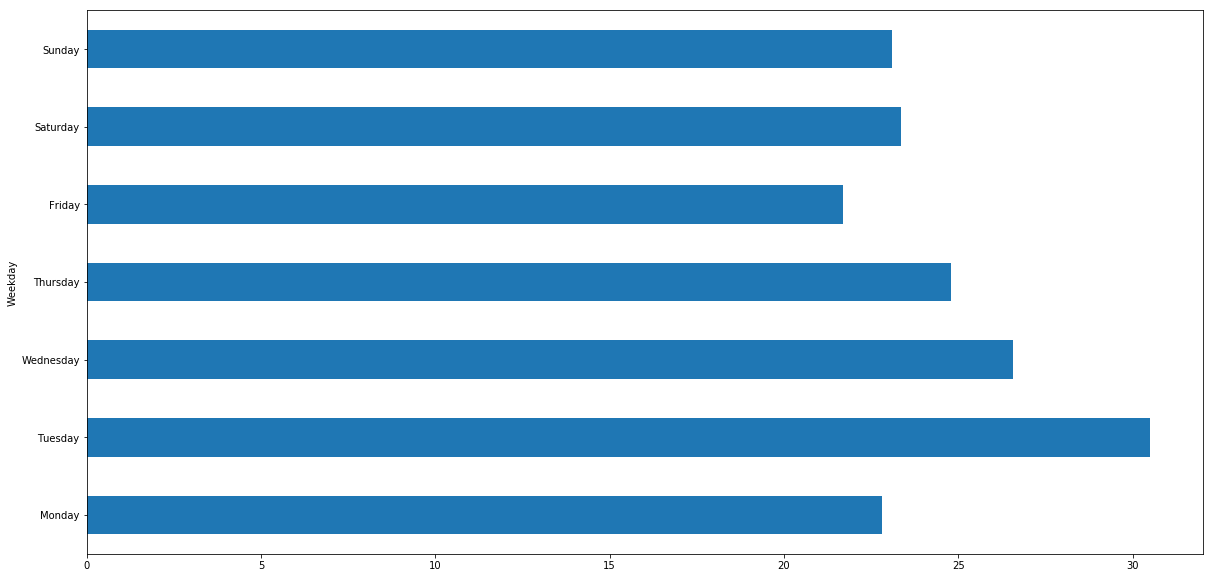

In [2075]:
byWeekday.mean().PagesRead.plot.barh()
plt.yticks(np.arange(7),dayNames)
plt.show()

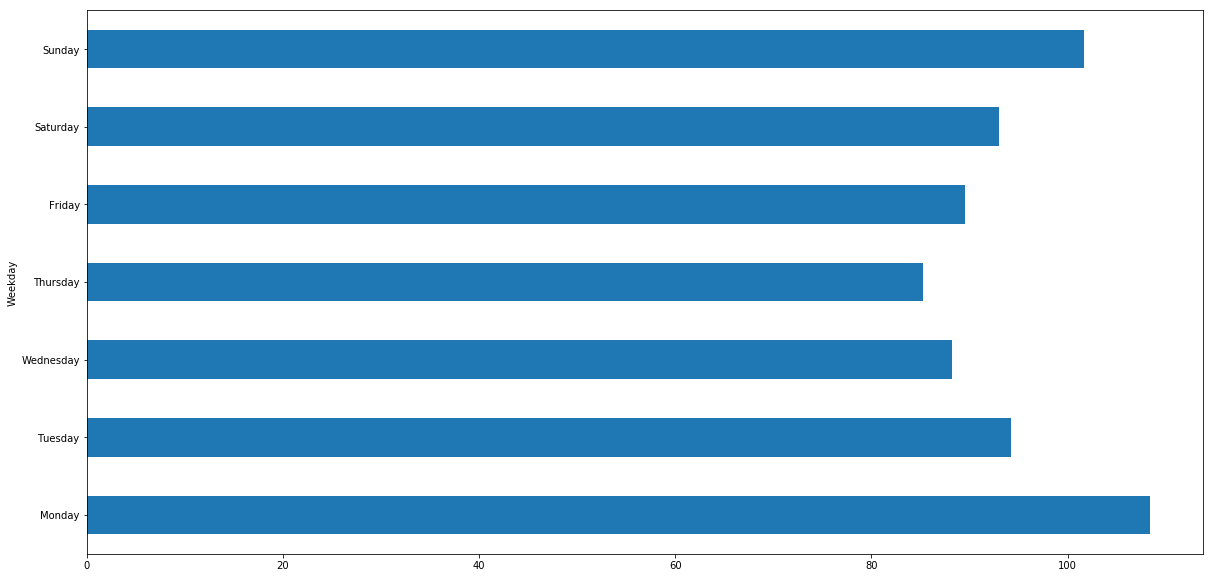

In [2076]:
byWeekday.mean().PerPageDuration_Seconds.plot.barh()
plt.yticks(np.arange(7),dayNames)
plt.show()

In [2077]:
byMonth = sess_table.groupby(sess_table['Month'])

In [2078]:
byMonth.sum()[['SessionDuration_Minutes','PagesRead']]

,SessionDuration_Minutes,PagesRead
Month,,
1.0,795.134302,494
2.0,0.000000,3
3.0,841.960355,998
4.0,2200.220721,1188
5.0,2867.398432,1468
6.0,1258.672393,967
7.0,1557.186519,1438
8.0,1993.405516,1329
9.0,852.504323,1601


In [2079]:
byMonth.mean()[['SessionDuration_Minutes', 'PerPageDuration_Seconds','PagesRead']]

,SessionDuration_Minutes,PerPageDuration_Seconds,PagesRead
Month,,,
1.0,39.756715,109.831204,24.700000
2.0,0.000000,0.000000,1.000000
3.0,32.383091,117.920913,38.384615
4.0,36.069192,117.767410,19.475410
5.0,36.761518,112.852919,18.820513
6.0,34.963122,81.561413,26.861111
7.0,25.527648,80.052341,23.573770
8.0,36.914917,97.893598,24.611111
9.0,22.434324,36.790050,42.131579


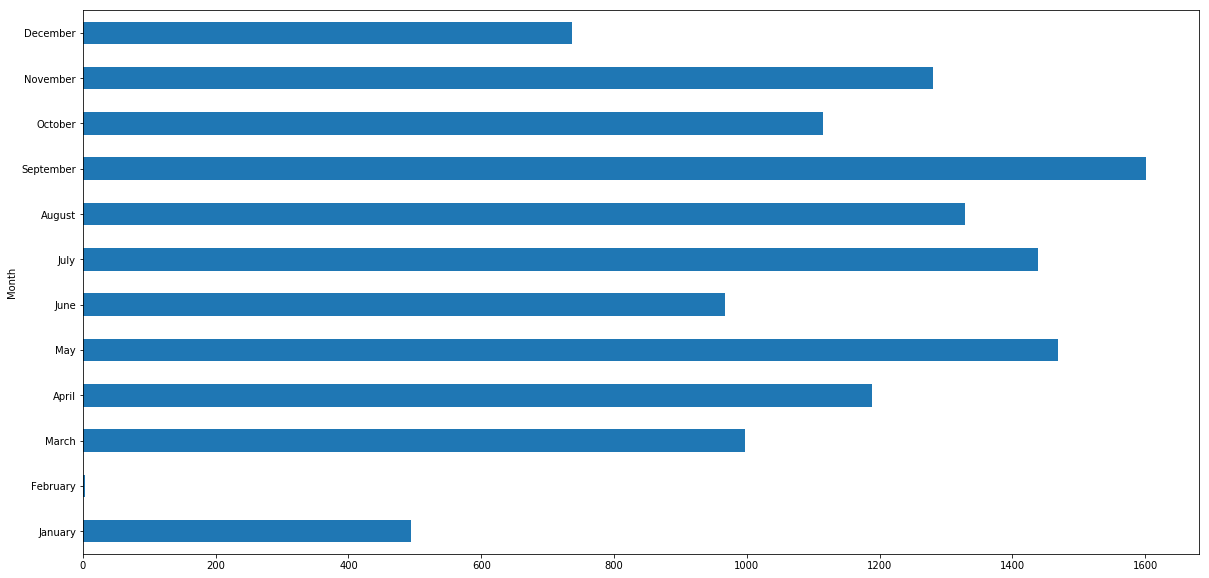

In [2080]:
byMonth.sum().PagesRead.plot.barh()
plt.yticks(np.arange(12),monthNames)
plt.show()

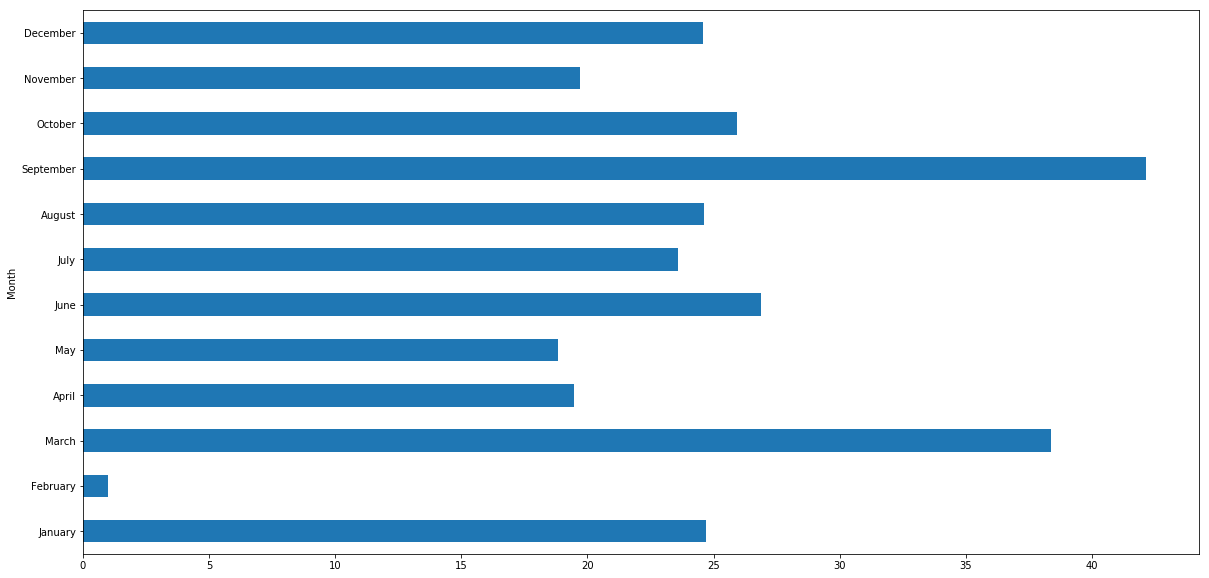

In [2081]:
byMonth.mean().PagesRead.plot.barh()
plt.yticks(np.arange(12),monthNames)
plt.show()

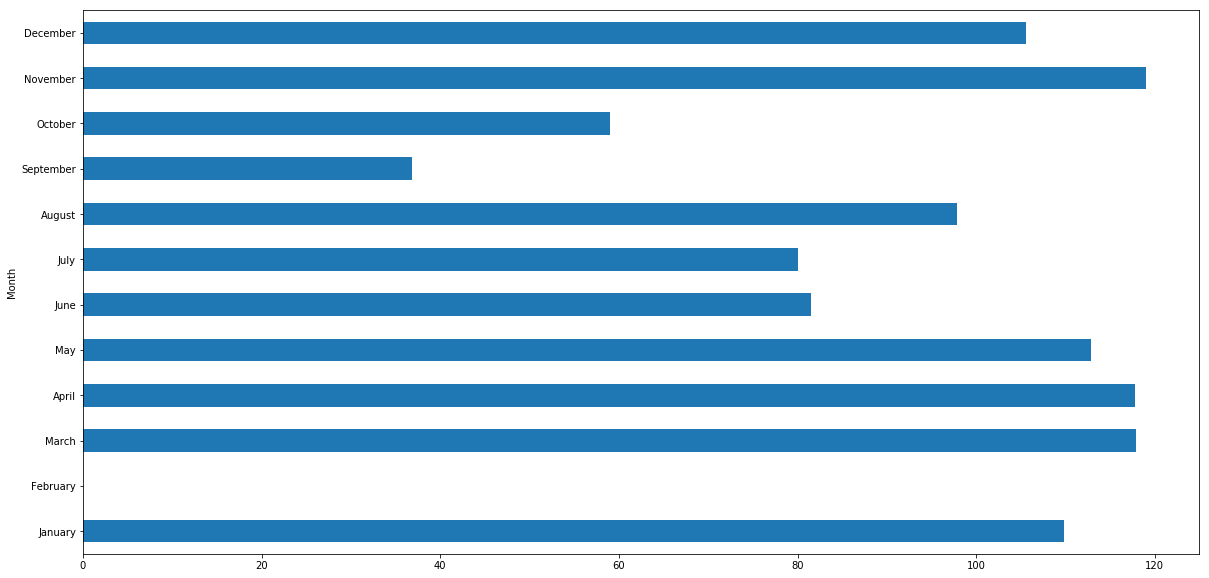

In [2082]:
byMonth.mean().PerPageDuration_Seconds.plot.barh()
plt.yticks(np.arange(12),monthNames)
plt.show()

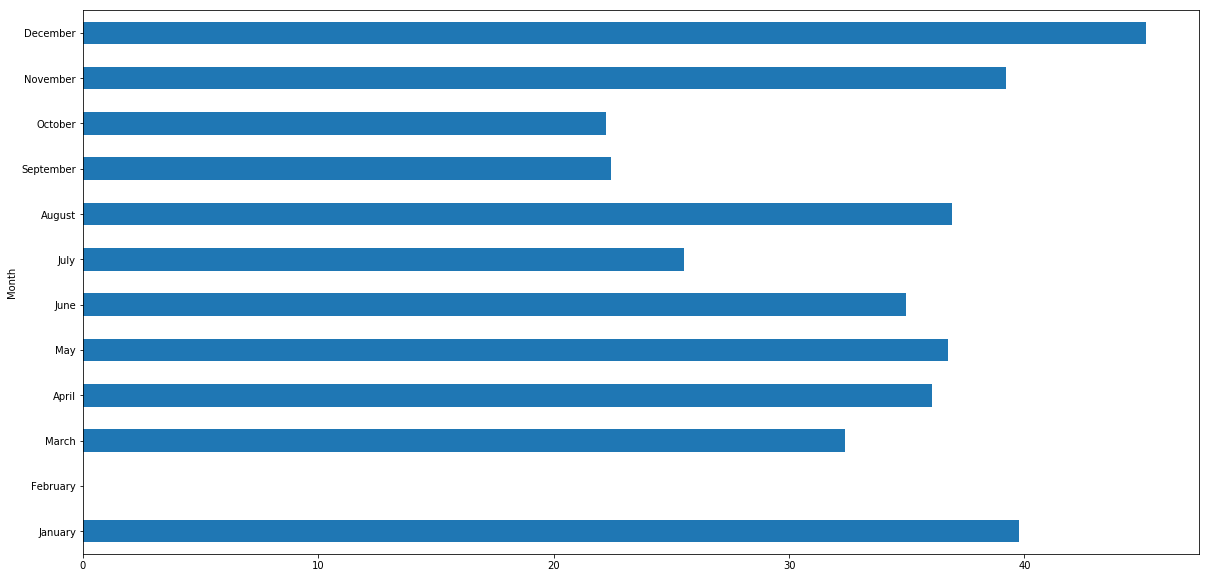

In [2083]:
byMonth.mean().SessionDuration_Minutes.plot.barh()
plt.yticks(np.arange(12),monthNames)
plt.show()

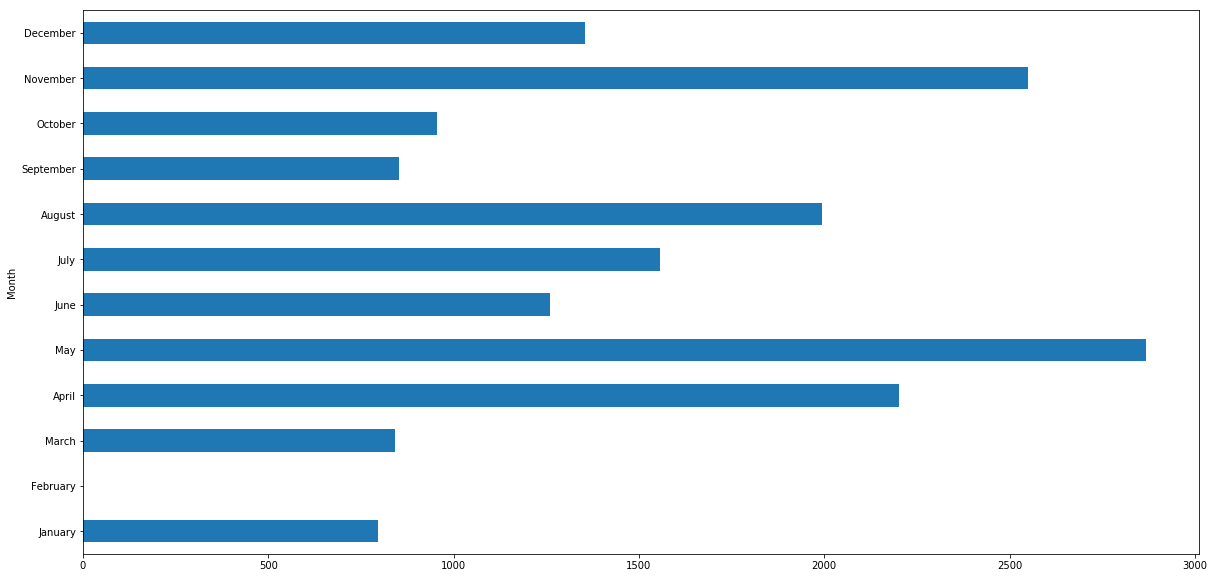

In [2084]:
byMonth.sum().SessionDuration_Minutes.plot.barh()
plt.yticks(np.arange(12),monthNames)
plt.show()

In [2085]:
archived = book_table[book_table.Archived == True]

In [2086]:
archived.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 45
Data columns (total 26 columns):
BookID                     30 non-null int64
Title                      30 non-null object
Author                     30 non-null object
FirstPage                  30 non-null int64
LastPage                   30 non-null int64
Key                        30 non-null object
ReadingUnit                30 non-null object
OutOfOrder                 30 non-null bool
Archived                   30 non-null bool
Date                       30 non-null object
Order                      30 non-null int64
BookType                   30 non-null object
Rating                     30 non-null int64
comment                    0 non-null float64
StartDate                  30 non-null object
ArchiveDate                30 non-null datetime64[ns]
Pages                      29 non-null float64
SessionCount               30 non-null int64
SessionDuration            30 non-null timedelta64[ns]
SessionDuration

In [2087]:
archived.sort_values('ArchiveDate')[['ArchiveDate','Title','Author','Pages','PerPageDuration','SessionCount', 
                             'SessionDuration',]]

,ArchiveDate,Title,Author,Pages,PerPageDuration,SessionCount,SessionDuration
41,2017-02-07 02:03:48,Ratification: The People Debate the Constituti...,Pauline Maier,NaN,NaT,0,0 days 00:00:00
42,2017-02-13 02:14:25,The Framers Coup,Michael J. Klarman,631.0,00:00:00,2,0 days 00:00:00
43,2017-02-17 02:17:14,Explaining America: The Federalist,Gary Wills,270.0,00:00:00,2,0 days 00:00:00
44,2017-02-25 02:22:12,Anti-Intellectualism in American Life,Richard Hofstatder,432.0,00:00:00,2,0 days 00:00:00
45,2017-03-07 02:25:22,Madison's Hand,Mary Sarah Bilder,262.0,00:00:00,2,0 days 00:00:00
0,2017-03-30 06:44:35,Washington: A Life,Ron Chernow,817.0,00:02:13.474947,22,0 days 13:31:44.692626
2,2017-04-27 21:00:11,"Plain, Honest Men: The Making of the American ...",Richard Beeman,423.0,00:01:39.746303,21,0 days 09:38:54.723784
1,2017-05-03 22:55:11,Alexander Hamilton,Ron Chernow,731.0,00:02:10.120944,44,1 days 04:00:14.400966
4,2017-05-04 14:55:25,The Goal A Process of Ongoing Improvement,Eliyahu M. Goldratt,359.0,00:00:37.580579,5,0 days 03:51:00.601992
12,2017-05-21 03:21:51,A Gambler's Anatomy,Jonathan Lethem,289.0,00:01:23.213627,14,0 days 06:45:44.861559


In [2088]:
book_table[['Pages', 'ElapsedSession', 'SessionDuration', 'PerPageDuration' ]].describe()

,Pages,ElapsedSession,SessionDuration,PerPageDuration
count,50.000000,48,51,49
mean,430.920000,32 days 07:23:06.708333,0 days 05:38:47.442308,0 days 00:01:14.572009
std,199.711612,54 days 20:42:16.101404,0 days 08:04:46.643293,0 days 00:01:08.295598
min,105.000000,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
25%,265.000000,0 days 20:21:40.500000,0 days 00:12:45.332198,0 days 00:00:28.271958
50%,410.500000,11 days 00:52:28,0 days 01:27:57.036187,0 days 00:01:16.617396
75%,561.000000,32 days 17:18:42.500000,0 days 07:25:06.260900,0 days 00:01:43.736542
max,853.000000,250 days 12:25:16,1 days 08:14:55.813031,0 days 00:06:37.133631


In [2089]:
book_table[book_table.Archived == True].Pages.sum()

12852.0

In [2090]:
book[book.archived == True].SessionDuration.sum()

Timedelta('11 days 05:43:06.132962')

In [2091]:
sess_table[sess_table.BookID == 0].PerPageDuration.mean()

Timedelta('0 days 00:02:13.474947')

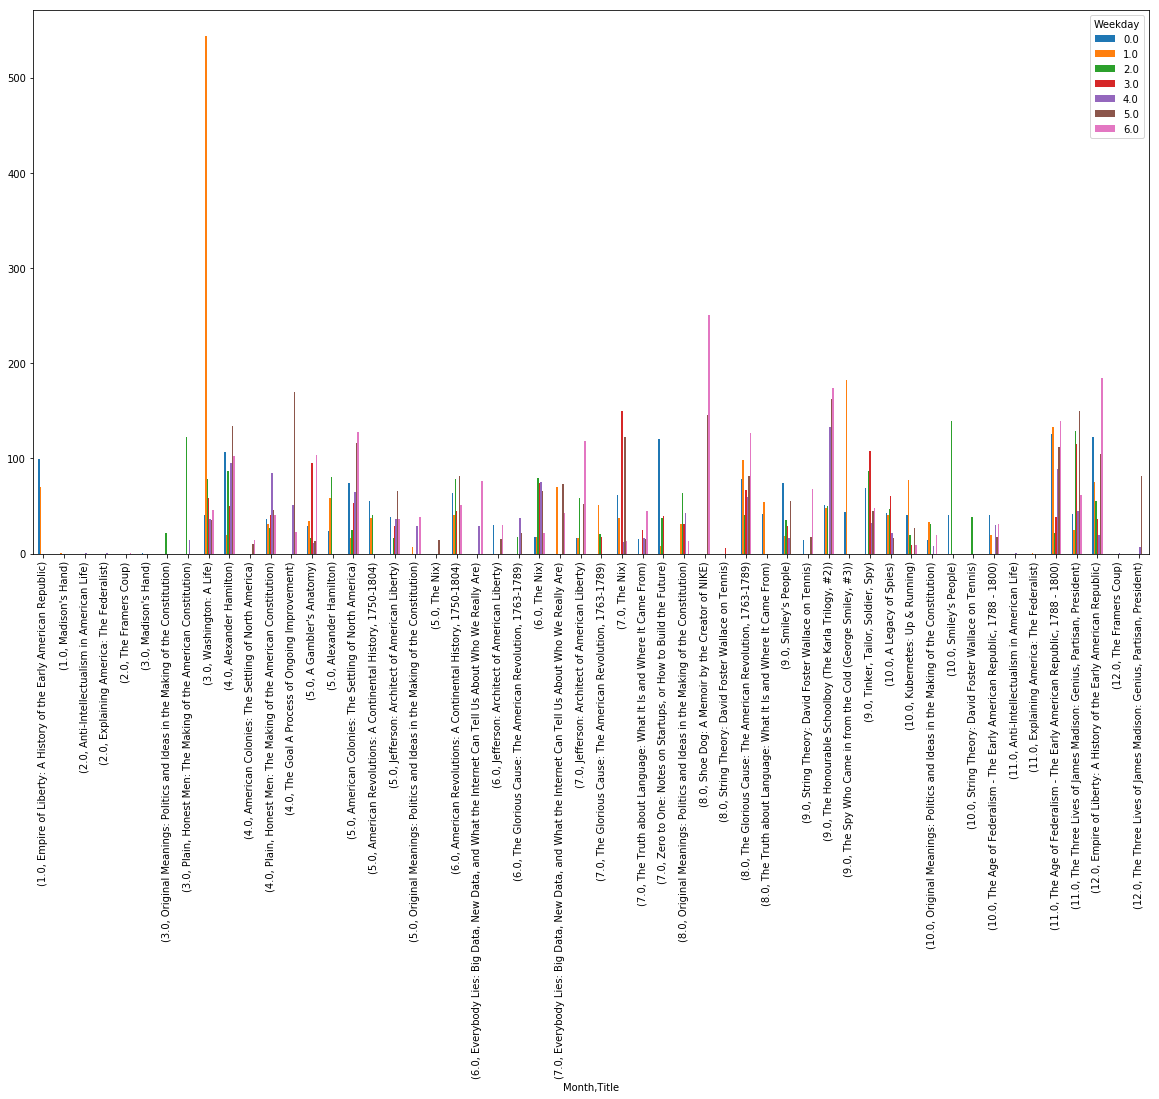

In [2092]:
sess_table[sess_table.Archived == True].pivot_table(index=["Month","Title"], columns="Weekday", values="PagesRead", aggfunc=np.sum).plot(kind="bar")

In [2093]:
sess_table[sess_table.Archived == True].pivot_table(index="Title", columns="Month", values="PagesRead", aggfunc=np.sum)

Month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
Title,,,,,,,,,,,,
A Gambler's Anatomy,NaN,NaN,NaN,NaN,302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Legacy of Spies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.0,NaN,NaN
Alexander Hamilton,NaN,NaN,NaN,595.0,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
American Colonies: The Settling of North America,NaN,NaN,NaN,24.0,477.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"American Revolutions: A Continental History, 1750-1804",NaN,NaN,NaN,NaN,133.0,361.0,NaN,NaN,NaN,NaN,NaN,NaN
Anti-Intellectualism in American Life,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Empire of Liberty: A History of the Early American Republic,169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596.0
"Everybody Lies: Big Data, New Data, and What the Internet Can Tell Us About Who We Really Are",NaN,NaN,NaN,NaN,NaN,105.0,186.0,NaN,NaN,NaN,NaN,NaN
Explaining America: The Federalist,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [2094]:
sess_table.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2017-03-07 05:00:00 to 2018-01-10 07:34:46
Data columns (total 31 columns):
BookID                          523 non-null int64
FirstSessionPage                523 non-null int64
LastSessionPage                 523 non-null int64
Key                             523 non-null object
Start                           523 non-null object
PagesRead                       523 non-null int64
Duration                        523 non-null timedelta64[ns]
PerPageDuration                 523 non-null timedelta64[ns]
SessionDuration_Minutes         523 non-null float64
PerPageDuration_Seconds         523 non-null float64
SessionStart                    63 non-null datetime64[ns]
SessionEnd                      515 non-null datetime64[ns]
SessionElapsed                  63 non-null timedelta64[ns]
SessionInterupt                 63 non-null timedelta64[ns]
Weekday                         515 non-null float64
Month                         

In [2095]:
sess_table[sess_table.SessionElapsed.notnull()][['Title','SessionStart', 'SessionEnd', 'Duration', 'SessionElapsed', 'SessionInterupt']]

,Title,SessionStart,SessionEnd,Duration,SessionElapsed,SessionInterupt
SessionDate,,,,,,
2017-12-07 20:23:13,Lean Enterprise: How High Performance Organiza...,2017-12-07 19:58:31,2017-12-07 20:23:13,00:24:42.566538,00:24:42,-1 days +23:59:59.433462
2017-11-25 06:37:12,The Age of Federalism - The Early American Rep...,2017-11-25 05:06:47,2017-11-25 06:37:12,00:36:15.525015,01:30:25,00:54:09.474985
2017-11-25 07:50:03,The Age of Federalism - The Early American Rep...,2017-11-25 07:11:20,2017-11-25 07:50:03,00:38:42.792823,00:38:43,00:00:00.207177
2017-11-25 19:39:14,The Age of Federalism - The Early American Rep...,2017-11-25 18:21:57,2017-11-25 19:39:14,00:44:31.938202,01:17:17,00:32:45.061798
2017-11-25 20:37:27,The Age of Federalism - The Early American Rep...,2017-11-25 19:51:00,2017-11-25 20:37:27,00:42:40.285519,00:46:27,00:03:46.714481
2017-11-25 22:27:41,The Age of Federalism - The Early American Rep...,2017-11-25 21:35:21,2017-11-25 22:27:41,00:27:10.175102,00:52:20,00:25:09.824898
2017-11-25 23:23:45,The Age of Federalism - The Early American Rep...,2017-11-25 22:55:01,2017-11-25 23:23:45,00:26:16.273743,00:28:44,00:02:27.726257
2017-11-26 01:56:22,The Age of Federalism - The Early American Rep...,2017-11-26 00:39:17,2017-11-26 01:56:22,00:46:29.823347,01:17:05,00:30:35.176653
2017-11-26 21:24:20,The Age of Federalism - The Early American Rep...,2017-11-26 19:14:08,2017-11-26 21:24:20,00:56:42.348844,02:10:12,01:13:29.651156
